In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

import pandas as pd
import numpy as np

import pulp

from typing import Optional, List,Tuple,Dict,Any,Hashable
from dataclasses import dataclass,field
from queue import PriorityQueue

# Phone Ranking Problem using UTA and AHP

Łukasz Andryszewski 151930

Choosing a new phone is often quite a daunting task, with many different models from different companies and varying prices.

In [2]:
data = pd.read_csv("./data/dataset.csv").set_index("name")
prefs = pd.read_csv("./data/preferences.csv")

In [3]:
data

,price-cost,ram-gain,screen-gain,disk-gain,oled-gain,os-gain,foldable-gain
name,,,,,,,
Huawei P30,1699,6.000,6.10,128,1,3,0
Huawei P20 Lite,899,4.000,5.80,64,0,3,0
Iphone 15,4699,6.000,6.70,128,1,0,0
Iphone 12,2499,4.000,6.10,64,1,0,0
Motorola Razr Ultra,3999,8.000,6.90,256,1,3,1
Motorola Razr 40,2999,8.000,6.90,256,1,3,1
Samsung Galaxy Z Flip 5,5599,8.000,6.70,256,1,3,1
Motorola Razr 8,2657,8.000,6.67,256,1,3,1
Nokia 2660 Flip,299,4.000,2.80,128,1,1,1


In [4]:
crit_types = [True if crit.split("-")[1]=="gain" else False for crit in data.columns ]
crit_types

[False, True, True, True, True, True, True]

In [5]:
data.columns = list(map(lambda s: s.split("-")[0],data.columns))
data

,price,ram,screen,disk,oled,os,foldable
name,,,,,,,
Huawei P30,1699,6.000,6.10,128,1,3,0
Huawei P20 Lite,899,4.000,5.80,64,0,3,0
Iphone 15,4699,6.000,6.70,128,1,0,0
Iphone 12,2499,4.000,6.10,64,1,0,0
Motorola Razr Ultra,3999,8.000,6.90,256,1,3,1
Motorola Razr 40,2999,8.000,6.90,256,1,3,1
Samsung Galaxy Z Flip 5,5599,8.000,6.70,256,1,3,1
Motorola Razr 8,2657,8.000,6.67,256,1,3,1
Nokia 2660 Flip,299,4.000,2.80,128,1,1,1


In [6]:
prefs

,id,preferred_to
0,0,1
1,4,6
2,8,11
3,3,2
4,3,9


In [7]:
for i,j in zip(prefs["id"],prefs["preferred_to"]):
	print(i,j)

0 1
4 6
8 11
3 2
3 9


In [8]:
def show_preferences(prefs,names,id_column="id",pref_column = "preferred_to"):
    for i,j in zip(prefs[id_column],prefs[pref_column]):
        print(f"{names[i]} is preferred to {names[j]}")

In [9]:
show_preferences(prefs,data.index)

Huawei P30 is preferred to Huawei P20 Lite
Motorola Razr Ultra is preferred to Samsung Galaxy Z Flip 5
Nokia 2660 Flip is preferred to Nokia 3310
Iphone 12 is preferred to Iphone 15
Iphone 12 is preferred to Huawei P40


## UTA method

In [10]:
@dataclass(order=True)
class BreakPoint:
	x: float
	y: pulp.LpVariable=field(compare=False)

	def __getitem__(self,key):
		if key == 0:
			return self.x
		elif key == 1:
			return self.y
		else:
			raise IndexError("Not a valid key '{}'".format(key))


class ValueFunction:
	def __init__(self,*args,**kwds):
		self.breakpoints = []
		for (i,j) in args:
			self.breakpoints.append(BreakPoint(i,j))
		
		self.breakpoints.sort()
		
		self.isGain = kwds["isGain"] if "isGain" in kwds else True
		self.name = kwds["name"] if "name" in kwds else None

	def __call__(self, *args: Any, **kwds: Any) -> Any:
		x = args[0]
		previous_breakpoint = None
		for break_point in self.breakpoints:
			if (x <= break_point.x): 
				break
			previous_breakpoint = break_point

		x2,y2 = break_point
		if previous_breakpoint != None:
			x1,y1 = previous_breakpoint

		if previous_breakpoint != None and previous_breakpoint != break_point:
			return (((x-x1)/(x2-x1)) * (y2-y1)) + y1 
		else: 
			return y2
	
	def __iadd__(self,xy):
		x,y = xy
		self.breakpoints.append(BreakPoint(x,y))
		self.breakpoints.sort()
		return self
	
	def __getitem__(self,key):
		if key < len(self.breakpoints):
			return self.breakpoints[key]
		else:
			return IndexError("Not a valid key '{}'".format(key))
		
	def __iter__(self):
		for b in self.breakpoints:
			yield b

		
	def __len__(self):
		return len(self.breakpoints)

	def marginal_worst(self):
		return self.breakpoints[0] if self.isGain else self.breakpoints[-1]
	
	def marginal_best(self):
		return self.breakpoints[-1] if self.isGain else self.breakpoints[0]

	def plot(self):
		# x1,y1 = self.breakpoints[0]
		# x2,y2 = self.breakpoints[-1]
		# x = np.arange(x1,x2+1,1)
		# y = [self(x_i) for x_i in x]
		x = [break_point.x for break_point in self.breakpoints]
		y = [break_point.y.varValue for break_point in self.breakpoints]
		if self.name != None: plt.title(self.name)
		plt.plot(x,y)
		plt.show()

class AdditiveValueFunction:
	def __init__(self,u_funcs:List[ValueFunction]):
		self.u_funcs = u_funcs
		#self.__weight_sum = np.sum(weights)

	def __getitem__(self,key):
		if key < len(self.u_funcs):
			return self.u_funcs[key]
		else:
			return IndexError("Not a valid key '{}'".format(key))
	
	def __iter__(self):
		for u in self.u_funcs:
			yield u

	def __call__(self,*alt,**kwds):
		return sum([self.u_funcs[i](crit) for i,crit in enumerate(alt)])
		#return sum((self.weights*values)/self.__weight_sum)



In [11]:
def create_U(data:pd.DataFrame,crit_types:List[bool],breakpoints=3):
	assert breakpoints >= 2
	u_max = 1/len(data.columns)
	u_funcs = []
	for crit_i,column_name in enumerate(data):
		column = data[column_name]
		_min = min(column)
		_max = max(column)

		_range = _max-_min
		_steps = _range/(breakpoints-1)

		breaks = [_min] + [_min + (_steps*(b+1)) for b in range(breakpoints-2)] + [_max]

		u = ValueFunction(isGain = crit_types[crit_i],name=column_name)
		for b in breaks:
			var = pulp.LpVariable(f"{column_name}_{b}",lowBound=0,upBound=1)
			u += (b,var)
		u_funcs.append(u)

		# best,worst = _max,_min
		# if not crit_types[crit_i]:
		# 	best,worst = worst,best
		# first,last = pulp.LpVariable(f"{column_name}_worst",lowBound=0,upBound=1),pulp.LpVariable(f"{column_name}_best",lowBound=0,upBound=1)
		# u_funcs.append(ValueFunction((worst,first),(best,last),isGain=crit_types[crit_i]))

		
	return AdditiveValueFunction(u_funcs)

In [12]:
U = create_U(data,crit_types,4)

In [13]:
def standard_criteria(U:AdditiveValueFunction,data:pd.DataFrame,min_thresh=0.05,max_thresh=0.5,prob_name="UTA method",prob_type=pulp.LpMaximize):

    crits = data.columns

    # Create LP problem
    prob = pulp.LpProblem(prob_name, prob_type)

    # Monotoncity criteria
    for j,u in enumerate(U):
        for i in range(len(u)-1):
            prob += u[i].y <= u[i+1].y if u.isGain else u[i].y >= u[i+1].y, f"monotonicity_{crits[j]}_{i}"

    # Normalization constraints for criteria
    for i,u in enumerate(U):
        prob += u.marginal_worst().y == 0, f"lowest_value_{crits[i]}"

    # min and max weights
    for i,u in enumerate(U):
        prob += u.marginal_best().y <= max_thresh, f"max_weight_{crits[i]}"
        prob += u.marginal_best().y >= min_thresh, f"min_weight_{crits[i]}"

    # norm of sum 
    prob += pulp.lpSum([u.marginal_best().y for u in U]) == 1, "norm_to_1"

    return prob

## 2.1 Maximal subset of consitent preferences

In [14]:
def minimal_subset(data:pd.DataFrame,prefs:pd.DataFrame,U:AdditiveValueFunction,equals:pd.DataFrame=None,with_vars=False):
	problem = standard_criteria(U,data,prob_name="minimal_subset",prob_type=pulp.LpMinimize)#pulp.LpProblem("minimal_subset")

	variables = dict([((i,j),pulp.LpVariable(f"v_{i}_{j}",cat=pulp.LpBinary)) for i,j in zip(prefs["id"],prefs["preferred_to"])])
	
	# objective function
	problem += pulp.lpSum([var for var in variables.values()])

	# preferences
	eps = 0.0001
	for (i,j),var in variables.items():
		alt_i,alt_j = data.iloc[i],data.iloc[j]
		problem += (U(*alt_i) >= U(*alt_j) - var + eps),f"{i}_preferred_to_{j}"

	return (problem) if not with_vars else (problem,variables)

In [15]:
def find_largest_consistent_set(data:pd.DataFrame,prefs:pd.DataFrame,U:AdditiveValueFunction):

    inconsistent = []
    consistent = []
    problem,variables = minimal_subset(data,prefs,U,with_vars=True)
    while True:
        if len(inconsistent) != 0:
            size = len(inconsistent[-1])
            problem += pulp.lpSum([variables[pair] for pair in inconsistent[-1]]) <= size-1

        problem.solve()
        consist_subset = []
        inconsist_subset = []
        for v in problem.variables():
            name = v.name.split("_")
            if name[0] != "v":
                continue
            if v.varValue == 1.0:
                inconsist_subset.append(tuple(map(int,(name[1],name[2]))))
            elif v.varValue == 0.0:
                consist_subset.append(tuple(map(int,(name[1],name[2]))))
        if problem.status == -1:
            return inconsistent,consistent
        inconsistent.append(inconsist_subset)
        consistent.append(consist_subset)

In [16]:
add_prefs = prefs.copy()
# inconsistent preferences
add_prefs.loc[len(add_prefs.index)] = [5,4] 
add_prefs.loc[len(add_prefs.index)] = [4,7]
add_prefs.loc[len(add_prefs.index)] = [7,5]

show_preferences(add_prefs,data.index)

Huawei P30 is preferred to Huawei P20 Lite
Motorola Razr Ultra is preferred to Samsung Galaxy Z Flip 5
Nokia 2660 Flip is preferred to Nokia 3310
Iphone 12 is preferred to Iphone 15
Iphone 12 is preferred to Huawei P40
Motorola Razr 40 is preferred to Motorola Razr Ultra
Motorola Razr Ultra is preferred to Motorola Razr 8
Motorola Razr 8 is preferred to Motorola Razr 40


In [30]:
inconsist,consist = find_largest_consistent_set(data,add_prefs,U)

In [31]:
def remove_prefs(prefs,vals):
    new_prefs = prefs.copy()
    for i,j in vals:
        new_prefs = new_prefs.drop(new_prefs[(new_prefs["id"]==i) & (new_prefs["preferred_to"]==j)].index)
    return new_prefs

In [34]:
reduced_prefs = remove_prefs(add_prefs,inconsist[-1])
show_preferences(reduced_prefs,data.index)

Huawei P30 is preferred to Huawei P20 Lite
Motorola Razr Ultra is preferred to Samsung Galaxy Z Flip 5
Nokia 2660 Flip is preferred to Nokia 3310
Iphone 12 is preferred to Iphone 15
Motorola Razr 40 is preferred to Motorola Razr Ultra
Motorola Razr Ultra is preferred to Motorola Razr 8


## 2.2 Ordinal Regression

In [20]:
def ordinal_regression(data:pd.DataFrame,prefs:pd.DataFrame,U:AdditiveValueFunction):

	problem = standard_criteria(U,data,prob_name="ordinal_regression",prob_type=pulp.LpMinimize)#pulp.LpProblem("ordinal_regression")

	over_estimates = [pulp.LpVariable(f"over_{i}",cat=pulp.LpContinuous,lowBound=0) for i in range(len(data))]
	under_estimates = [pulp.LpVariable(f"under_{i}",cat=pulp.LpContinuous,lowBound=0) for i in range(len(data))]
	
	# objective function
	problem += pulp.lpSum([var for var in over_estimates] + [var for var in under_estimates])	

	# preferences
	eps = 0.0001 # epsilon for modelling sharp inequalities	
	for i,j in map(list,prefs.iloc):
		alt_i,alt_j = data.iloc[i],data.iloc[j]
		problem += (U(*alt_i) - over_estimates[i] + under_estimates[i] >= U(*alt_j) - over_estimates[j] + under_estimates[j] + eps), f"{i}_>_{j}"

	return problem

In [21]:
def solve_problem(problem):
    problem.solve()
    print("Status:", pulp.LpStatus[problem.status])
    print("Optimal Solution:")
    for v in problem.variables():
        print(v.name, "=", v.varValue)
    print("Optimal Objective Value:", pulp.value(problem.objective))

In [22]:
problem = ordinal_regression(data,reduced_prefs,U)
problem

ordinal_regression:
MINIMIZE
1*over_0 + 1*over_1 + 1*over_10 + 1*over_11 + 1*over_12 + 1*over_13 + 1*over_14 + 1*over_2 + 1*over_3 + 1*over_4 + 1*over_5 + 1*over_6 + 1*over_7 + 1*over_8 + 1*over_9 + 1*under_0 + 1*under_1 + 1*under_10 + 1*under_11 + 1*under_12 + 1*under_13 + 1*under_14 + 1*under_2 + 1*under_3 + 1*under_4 + 1*under_5 + 1*under_6 + 1*under_7 + 1*under_8 + 1*under_9 + 0
SUBJECT TO
monotonicity_price_0: price_100 - price_1933.0 >= 0

monotonicity_price_1: price_1933.0 - price_3766.0 >= 0

monotonicity_price_2: price_3766.0 - price_5599 >= 0

monotonicity_ram_0: ram_0.004 - ram_4.002666666666666 <= 0

monotonicity_ram_1: ram_4.002666666666666 - ram_8.001333333333333 <= 0

monotonicity_ram_2: - ram_12.0 + ram_8.001333333333333 <= 0

monotonicity_screen_0: screen_1.7 - screen_3.4333333333333336 <= 0

monotonicity_screen_1: screen_3.4333333333333336 - screen_5.166666666666667
 <= 0

monotonicity_screen_2: screen_5.166666666666667 - screen_6.9 <= 0

monotonicity_disk_0: disk_16 

In [23]:
solve_problem(problem)

Status: Optimal
Optimal Solution:
disk_16 = 0.0
disk_181.33333333333334 = 0.0
disk_346.6666666666667 = 0.0
disk_512 = 0.05
foldable_0 = 0.0
foldable_0.3333333333333333 = 0.0
foldable_0.6666666666666666 = 0.0
foldable_1 = 0.5
oled_0 = 0.0
oled_0.3333333333333333 = 0.0
oled_0.6666666666666666 = 0.0
oled_1 = 0.05
os_0 = 0.0
os_1.0 = 0.0
os_2.0 = 0.0
os_3 = 0.25
over_0 = 0.0
over_1 = 0.0
over_10 = 0.0
over_11 = 0.0
over_12 = 0.0
over_13 = 0.0
over_14 = 0.0
over_2 = 0.0
over_3 = 0.0
over_4 = 0.0
over_5 = 0.0
over_6 = 0.0
over_7 = 0.0
over_8 = 0.0
over_9 = 0.0
price_100 = 0.05
price_1933.0 = 0.0020342158
price_3766.0 = 0.0020342158
price_5599 = 0.0
ram_0.004 = 0.0
ram_12.0 = 0.05
ram_4.002666666666666 = 0.0
ram_8.001333333333333 = 0.0
screen_1.7 = 0.0
screen_3.4333333333333336 = 0.0
screen_5.166666666666667 = 0.047297678
screen_6.9 = 0.05
under_0 = 0.0
under_1 = 0.0
under_10 = 0.0
under_11 = 0.0
under_12 = 0.0
under_13 = 0.0
under_14 = 0.0
under_2 = 0.0
under_3 = 0.0
under_4 = 0.0
under_5 = 

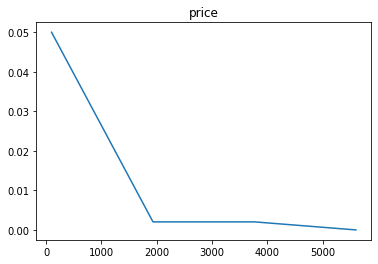

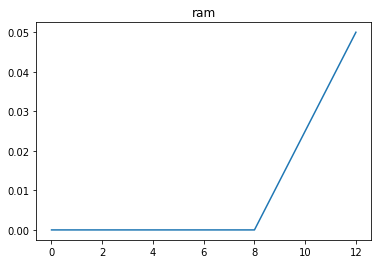

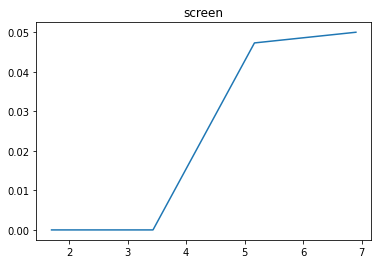

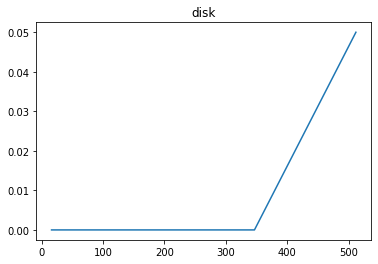

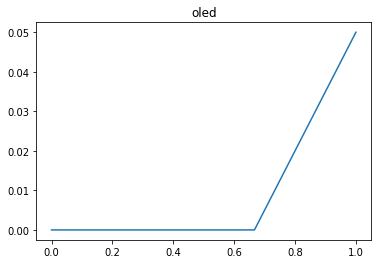

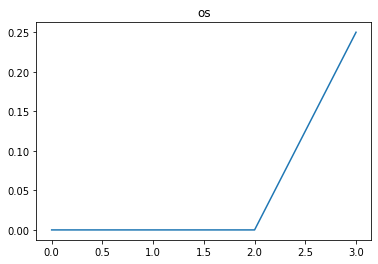

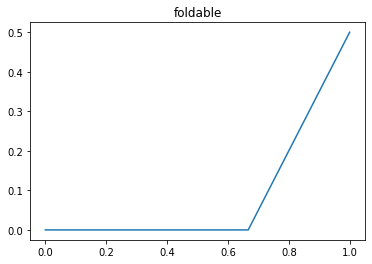

In [24]:
for u in U:
    u.plot()

In [25]:
for i in range(len(data)):
    print(i,U(*data.iloc[i]).value())


0 0.3569102818615385
1 0.32737690254102564
2 0.10068699024386252
3 0.10078699026153846
4 0.8517756384506274
5 0.8520342158
6 0.8496881936153846
7 0.8516756384576923
8 0.5947925853487179
9 0.10078699026153846
10 0.35156650622307695
11 0.05
12 0.3758514336051282
13 0.4577989300576923
14 0.3632351867717949


## AHP

In [297]:
class Node:
    def __init__(self,value,children):
        self.children = children
        self.value = value
        n = len(children)
        self.n = n
        self.comparisons = np.ones((n,n))
        self.weights = np.ones(n)
        self.lambda_max = None
    
    def add_comparisons(self,comps):
        self.comparisons = np.array(comps)

    def draw(self,graph=None,parent=None):
        if graph == None:
            graph = nx.DiGraph()
        graph.add_node(self.value)
        if parent != None:
            graph.add_edge(parent,self.value)
        for child in self.children:
            child.draw(graph,self.value)
        if parent == None:
            plt.figure(3,figsize=(12,12)) 
            pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")
            nx.draw(graph,pos, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_color='black')
            plt.show()

    def calc_weights(self,power=10):
        lambs,eigvec = np.linalg.eig(self.comparisons)

    
        #principal = eigvec[np.argmax(lambs)] #shenanigans with complex number
        ape = np.linalg.matrix_power(self.comparisons,power) @ np.ones(self.n)
        self.weights = ape/np.sum(ape)
        self.lambda_max = np.abs(np.max(lambs))
    
    def consistency_index(self):
        assert self.lambda_max != None
        return np.around((self.lambda_max - self.n)/(self.n -1),4)

    def __repr__(self):
        return f"Node {self.value}"

### Hierarchy

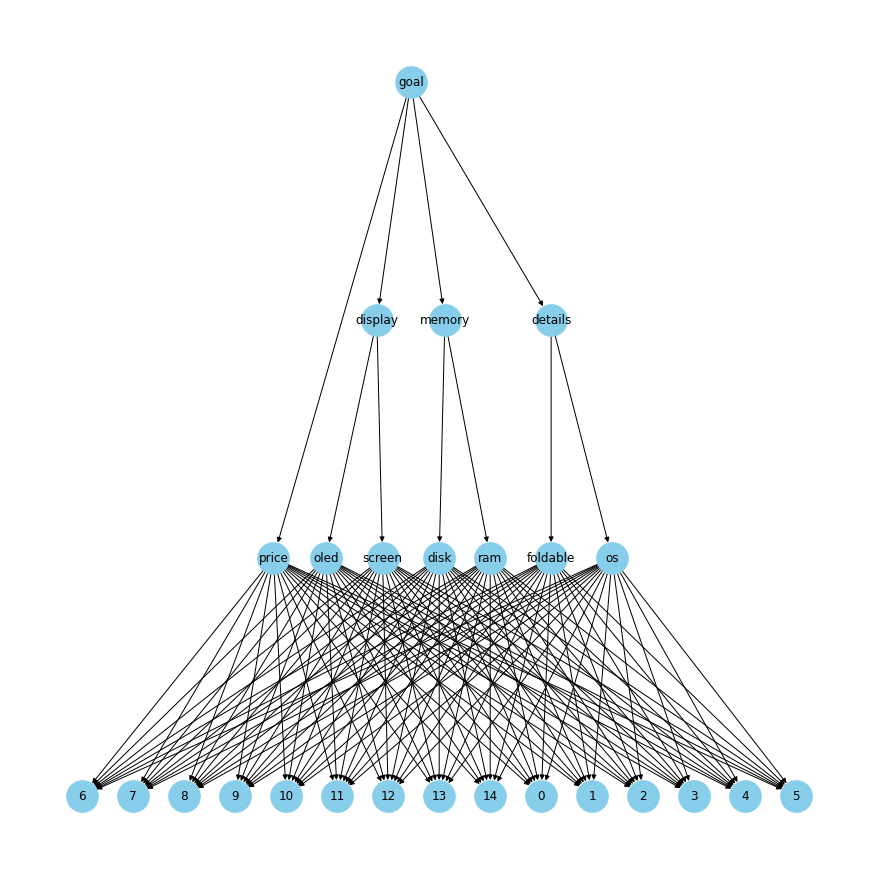

In [298]:
alternatives = [Node(f"{i}",[]) for i in range(len(data))]

nodes = dict([(crit,Node(crit,alternatives))for crit in data])

crit_cat = [Node("display",[nodes["screen"],nodes["oled"]]),
            Node("memory",[nodes["ram"],nodes["disk"]]),
            Node("details",[nodes["os"],nodes["foldable"]])]

for node in crit_cat + alternatives:
    nodes[node.value] = node

goal = Node("goal",crit_cat + [nodes["price"]])

nodes["goal"] = goal

goal.draw()

In [299]:
nodes["goal"].children

[Node display, Node memory, Node details, Node price]

In [300]:
nodes["goal"].add_comparisons([[1,0.5,0.5,0.1],
                                [2,1,0.5,0.1],
                                [2,2,1,0.8],
                                [10,10,1.25,1]])

nodes["display"].add_comparisons([[1,0.2],
                                [3,1]])

nodes["memory"].add_comparisons([[1,2],
                                [0.5,1]])

nodes["details"].add_comparisons([[1,10],
                                [0.1,1]])

In [301]:
def calc_comparisons(data:pd.DataFrame,nodes:Dict[Hashable,Node]):
    
    n = len(data)

    def safe_div(a,b):
        return a/b if a != 0 and b != 0 else (a+1)/(b+1)

    for crit in data:
        comparisons = np.ones((n,n))
        for i,row_i in enumerate(data.iloc):
            for j,row_j in enumerate(data.iloc[i+1:].iloc,i+1): #in range(i+1,len(data)):
                #row_j = data.iloc[j]
                comparisons[i,j] = safe_div(row_i[crit],row_j[crit])
                comparisons[j,i] = safe_div(row_j[crit],row_i[crit])
        nodes[crit].add_comparisons(comparisons)


In [302]:
calc_comparisons(data,nodes)

In [303]:
nodes["price"].calc_weights()